# Raindrops keep falling ...

## Introduction

I have recently been creating visualizations of water quality measurements, obtained at over 100 sites, over a period of years.  The physical parameter measurements (Turbidity, pH, Salinity, etc) are collected monthly at each site by volunteers.  See __[Example Graphic](https://coolum001.github.io/tsbn.html)__  for details of the data processing to get a graphic in the form required by the data collection manager.

One physical quantity that I thought was missing was recent rainfall in the area around the measurement site.  So, I thought I would poke around to see how I could get monthly rainfall data into the graphics.

## Data Sources

### BoM
The obvious organization to turn to in Australia is the Bureau of Meteorology.  They indeed have a page labelled __[Climate Data Online](http://www.bom.gov.au/climate/data/index.shtml)__  that does  allow you to specify a weather station,  and monthly rainfall as the data item of interest, and get back a webpage that looks (in part) like:



| Year | Jan | Feb | Mar | Apr | May | Jun | Jul | Aug | Sep | Oct | Nov | Dec | Annual |
| ---: | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1995 | 6.6 | 83.0 | 95.2 | 172.2 | 107.2 | 62.8 | 8.4 | 37.0 | 28.2 | 124.0 | 64.0 | 154.2 | 1042.8 |


Great, I thought to myself, that API for getting this page is fairly obvious: _040861_ is the Id of the weather station of the Sunshine Coast Airport

```
http://www.bom.gov.au/jsp/ncc/cdio/weatherData/av?p_nccObsCode=139&p_display_type=dataFile&p_startYear=&p_c=&p_stn_num=040861
```

For each water quality measument site, I will get the closest weather station that recorded data for the period I am interest in, and get the monthly rainfall by web scraping.  Now this is a little less than ideal, in that the closest weather station might be downsteam of the measurement site, or might be over the range in the catchment area for a completely different stream or river.  But it would be a start, especially as the BoM do provide a download (in CSV form) of the locations of their weather stations.

### Implementation
#### Imports

In [59]:
import requests
from bs4 import BeautifulSoup as bs

import pandas as pd
import io

import matplotlib.pyplot as plt

#### Supporting Libraries
```lab black``` auto-formats the notebook, ```watermark``` allows the execution environment to be recorded

In [60]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [61]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


#### Code

Define the URL of the BoM webpage we are interested in (top-level to begin with).

In [62]:
url = 'http://www.bom.gov.au/climate/data/index.shtml'

Get the web page.

In [63]:
page = requests.get(url)
print(page)

<Response [403]>


__WTF__.  403 as a return status to an HTML request is not good:  

 >"The HTTP 403 Forbidden response status code indicates that the server understands the request but refuses to authorize it."


Let us probe a little deeper.

In [64]:
print(page.content.decode()[0:250], '...')

<p>Your access is blocked due to the detection of a potential automated access request. The Bureau of Meteorology website does not support web scraping: if you are trying to access Bureau data through automated means, you should stop. You may like to ...


#### Conclusion

So using the BoM is not feasible.  

### The Long Paddock

I eventually googled my way to a website provided by the Queensland Goverment, called ```The Long Paddock```, for providing "Climate risk information for rural Queensland".  The Long Paddock is a term for the stock routes: roads that stock owners were allowed to use to move cattle or sheep between properties, or to market.  In times of drought, the stock routes were used (or abused) to feed starving stock - the rule was that you had to keep moving, but ...

```
SALTBUSH BILL by A. B. 'Banjo' Paterson

Now this is the law of the Overland that all in the West obey -
A man must cover with travelling sheep a six-mile stage a day;
But this is the law which the drovers make, right easily understood,
They travel their stage where the grass is bad, but they camp where the grass is good;
They camp, and they ravage the squatter's grass till never a blade remains,
Then they drift away as the white clouds drift on the edge of the saltbush plains;
```

The LongPaddock website has a documented API, which is described in __[API](https://www.longpaddock.qld.gov.au/silo/api-documentation/)__

A typical URL looks like:



In [65]:
url = (
    'https://www.longpaddock.qld.gov.au/cgi-bin/silo/DataDrillDataset.php?'
    'start=20150101&'
    'finish=20221231&'
    'lat=-26.526&'
    'lon=153.086&'
    'format=monthly&'
    'comment=R'
    '&username=donrcameron@gmail.com&password=apirequest'
)

In the above, 

- `start` and `finish` are the date range requested, in yyyymmdd format
- `lat` and `lon` are the latitude and and logitude of a location  (in the case above, near my home)
- `format` specifies the type of data returned (this can be confusing - format can be set to `json` to get a response in JSON syntax, but `monthly` returns fixed width text table).
- `comment` is used to specify that `R`ainfall is required
- `username` and `password` are used to identify the caller.  It is not clear if the username email address is validated (I didn't want to look like a hacker, so never tested to API with an invalid email)

In [66]:
page = requests.get(url)
print(page)

<Response [200]>


This is better, a valid OK response received from our HTML request.  Let us look at the results:

In [67]:
print(page.content.decode()[0:200])

"199705"  -9.9  -9.9 9999.9 999.9  99.9  99.9"
""
" This file is SPACE DELIMITED for easy import into both spreadsheets and programs."
"The first line 199705 contains dummy data and is provided to all


The returned text has quite a large header:  moving deeper into the response, we get as below.  The column we want is `Tot Rain (mm)` 

In [68]:
print(page.content.decode()[1500:2000])

======================================"
Yr.Mth Avg   Avg   Tot   Tot    Avg   Avg
YYYYMM TMax  TMin  Rain  Evap   Rad    VP
()     (oC)  (oC)  (mm)  (mm) (MJ/m2) (hPa)
20150100  29.8  22.3  145.2 162.5  18.7  25.5
20150200  28.6  21.3  386.5 136.8  20.5  23.9
20150300  29.6  21.2   88.4 142.7  20.4  23.5
20150400  26.2  16.7  207.9 103.5  16.0  18.9
20150500  24.3  13.9  110.6  87.8  14.7  16.5
20150600  21.7  13.2   96.7  65.8  10.6  15.6
20150700  21.2  10.7   42.8  75.7  13.6  13.2
20150800  


Notice that LongPaddock automatically provides me monthly rainfall data for a location, that is __not__ a BoM weather station; as the website says:
 >`gridded datasets are constructed by spatially interpolating the observational data. Ordinary kriging is used to interpolate daily and monthly rainfall`.  
 
 So my concerns about using inappropriate rainfall data are now dispelled.
 
To visualize this data, we get  it into a `pandas` DataFrame.

In [69]:
# get the web page text string into a form pandas can perform I/O on

io_text = io.StringIO(page.content.decode())

# read the fixed width fields
df = pd.read_fwf(
    io_text,
    skiprows=24,
    widths=[
        4,
        2,
        2,
        6,
        6,
        7,
        6,
        6,
        6,
    ],
)

# rename the columns
df.columns = [
    'Year',
    'Month',
    'Day',
    'TMax',
    'TMin',
    'Rain',
    'Evap',
    'Rad',
    'VP',
]

# display the last record
df.tail(1)

,Year,Month,Day,TMax,TMin,Rain,Evap,Rad,VP
95,2022,12,0,27.0,19.0,106.7,175.6,21.2,20.8


Check the data types are as expected (they are):

In [70]:
df.dtypes

Year       int64
Month      int64
Day        int64
TMax     float64
TMin     float64
Rain     float64
Evap     float64
Rad      float64
VP       float64
dtype: object

Create a timestamp column from the separate Year and Month columns

In [71]:
df['tstamp'] = [
    pd.Timestamp(year=y, month=m, day=1)
    for y, m in zip(df['Year'], df['Month'])
]
df.head(4)

,Year,Month,Day,TMax,TMin,Rain,Evap,Rad,VP,tstamp
0,2015,1,0,29.8,22.3,145.2,162.5,18.7,25.5,2015-01-01
1,2015,2,0,28.6,21.3,386.5,136.8,20.5,23.9,2015-02-01
2,2015,3,0,29.6,21.2,88.4,142.7,20.4,23.5,2015-03-01
3,2015,4,0,26.2,16.7,207.9,103.5,16.0,18.9,2015-04-01


As expected, the timestamps are a calendar month apart.  Perform a quick plot of the data.


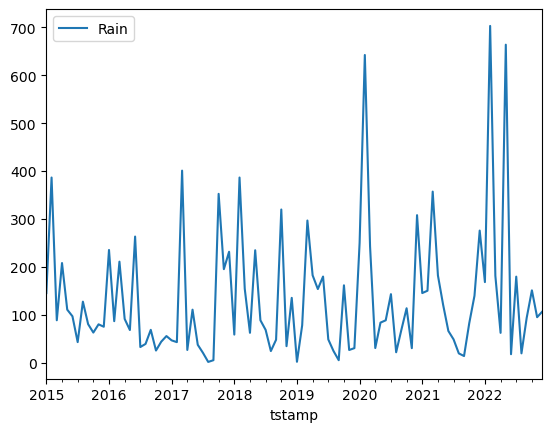

In [72]:
_ = df.plot(x='tstamp', y='Rain')

I am a unhappy with this plot.  The Monthly Rainfall should be spread across the whole month, not shown as occuring at day 1 of each month.

We define two helper functions:  

- one that, given a time stamp, returns a timestamp for the first of the month
- the second, that returns a timestamp for the first of the next month

In [73]:
def month_start(t: pd.Timestamp) -> pd.Timestamp:
    return pd.Timestamp(
        year=t.year,
        month=t.month,
        day=1,
    )


# end month_start


def next_month_start(t: pd.Timestamp) -> pd.Timestamp:
    return pd.Timestamp(
        year=t.year,
        month=t.month,
        day=1,
    ) + pd.DateOffset(months=1)


# end next_month_start

Now we create expand our list of timestamps into a list twice as long, in which for each original timestamp, we have the start of month and start of next month timestamps.

In [74]:
# for each timestamp, create a tuple, and then iterate over that tuple

month_start_end_dates = [
    t
    for r in df['tstamp']
    for t in (month_start(r), next_month_start(r))
]

We have to create a new list of rainfall data, with each value duplicated.  As above, for each original value, we create a tuple, and iterate over that.

In [75]:
rain2 = [
    r for pair in zip(df['Rain'], df['Rain']) for r in pair
]

Plot the result.

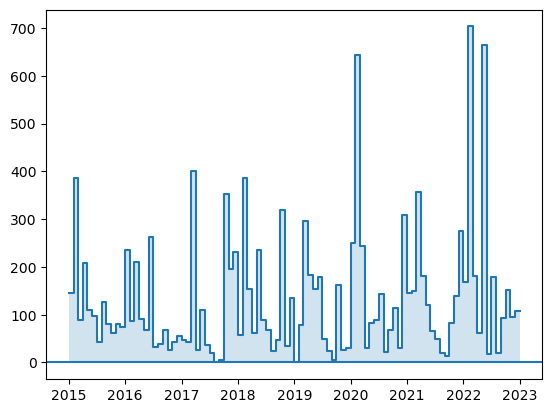

In [76]:
#  plot the monthly rainfall as a line
_ = plt.plot(month_start_end_dates, rain2)

# fill in down to y=0 line

_ = plt.fill_between(
    x=month_start_end_dates,
    y1=rain2,
    alpha=0.2,
)

# plot the y=0 line
_ = plt.axhline(0)

This is better representation of the fact that monthly rainfall is a property of the whole month, and not just a single day in that month.

## Validation

In order to validate this mechanism of getting monthly rainfallfor a specified location, I used that fact that I have been recoding daily rainfall at my home in Coolum Beach for the last few years, and recording these in a spreadsheet.

In [77]:
mydata_url = '../data/homerain.csv'

In [78]:
home_df = pd.read_csv(mydata_url)

We do a quick (non-pretty) comparison of the estimate from Long Paddock, and an extract from my rain gauge measurements.
We look at the months since January 2020, when I started daily measurements. My measurements for January 2020 are a little suspect, as I was away most of the month.

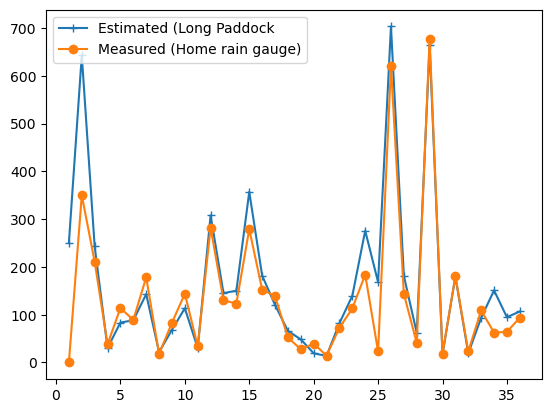

In [79]:
# get month numbers for 3 years, with Jan 2020 as month 1
plt.plot(
    range(1, 3 * 12 + 1),
    df[df['Year'] > 2019]['Rain'],
    label='Estimated (Long Paddock',
    marker='+',
)

plt.plot(
    range(1, 3 * 12 + 1),
    home_df['Rain'],
    label='Measured (Home rain gauge)',
    marker='o',
)
_ = plt.legend()

### Conclusion

The agreement between the Long Paddock estimates and my home rain gauge measurements are close enough to warrent inclusion of the Long Paddock estimates in the Water Quality graphs, as background information.

-----------------
## Execution Environment

In [80]:
%watermark

Last updated: 2023-07-12T19:32:48.039408+10:00

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 7.31.1

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [81]:
%watermark -co -iv

conda environment: base

matplotlib: 3.5.2
requests  : 2.28.1
pandas    : 1.4.4

